In [1]:
#%pip install datasets
%pip install transformers
%pip install evaluate
%pip install huggingface_hub

For datasets, there are a lot of issues with the version type when running on a cuda core, a guranteed safe
way to run is on a cpu, hence it is left commented out first.  If it throws an error, reinstall dataset OR update with %pip install -U datasets, then run load_dataset again in line 36 and 37. 

If it still doesn't work, update datasets again, clear all outputs, and re-comment out the %pip install -U datasets line. Before running all again. The correct output for bloc 6 is the image with the notebooks

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:

# Set random seed for NumPy
np.random.seed(28)

# Set random seed for PyTorch
torch.manual_seed(28)

# Set random seed for PyTorch CUDA (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(28)
    
# Set random seed for the transformer model
from transformers import set_seed
set_seed(28)

2024-04-09 09:35:21.766911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 09:35:21.766963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 09:35:21.768590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#To access the model and datasets in a format, login below. API is in readme.
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset # Used to load data from hugging face repositry, if error, see the markdown above. 


In [6]:
raw_datasets = load_dataset('J3nsenn/Output-features_10k')
raw_datasets


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 2000
    })
})

In [7]:
#Tokenizing the text data
from transformers import AutoTokenizer, DataCollatorWithPadding
raw_datasets = load_dataset('J3nsenn/Output-features_10k')
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
#Check that label, input_ids & attenion_mask are present
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [9]:
#Remove irrelevant columns to only have 3 taken in by the model
tokenized_datasets = tokenized_datasets.remove_columns(["Unnamed: 0","text",])
tokenized_datasets.set_format("torch")
print(tokenized_datasets["train"].column_names)
print(tokenized_datasets["test"].column_names)
print(tokenized_datasets["validation"].column_names)

['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']


In [10]:
#Run for taking the testing dataset only 
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=8, collate_fn=data_collator
)

In [11]:
for batch in test_dataloader: # change to test_loader, eval_loder or train_loader based on what you wish to check as properly initialised
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512]),
 'labels': torch.Size([8])}

# Import model from hugging face repo for use

In [12]:
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("J3nsenn/fine-tuned-distilbertv3")


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Used a cuda else cpu
model.to(device)
device

device(type='cuda')

In [14]:
# This is to ensure that the model is on the same device as the tensors
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Generation of evaluation metrics

In [15]:
#Code with loss metrics included
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

#Prepare lists to store true labels, predicted labels, test losses, and test accuracies
true_labels = []
predicted_labels = []
eval_losses = []
eval_accuracies = []

#Set model to evaluation mode
model.eval()


progress_bar = tqdm(test_dataloader, desc="Testing")

#Iterate over the test dataset
for batch in progress_bar:
    with torch.no_grad():
        #Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        #Forward pass
        outputs = model(**batch)
        logits = outputs.logits
        
        _, predicted = torch.max(logits, dim=1)
        
        #Append true labels and predicted labels to lists
        true_labels.extend(batch['labels'].cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        #Compute test loss
        eval_loss = outputs.loss.item()
        eval_losses.append(eval_loss)
        
        #Compute test accuracy
        eval_accuracy = accuracy_score(batch['labels'].cpu().numpy(), predicted.cpu().numpy())
        eval_accuracies.append(eval_accuracy)

#Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

#Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

#Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')




Testing:   0%|          | 0/250 [00:00<?, ?it/s]

Confusion Matrix:
[[997   3]
 [  3 997]]
Accuracy: 0.997
Precision: 0.997
Recall: 0.997
F1-score: 0.997


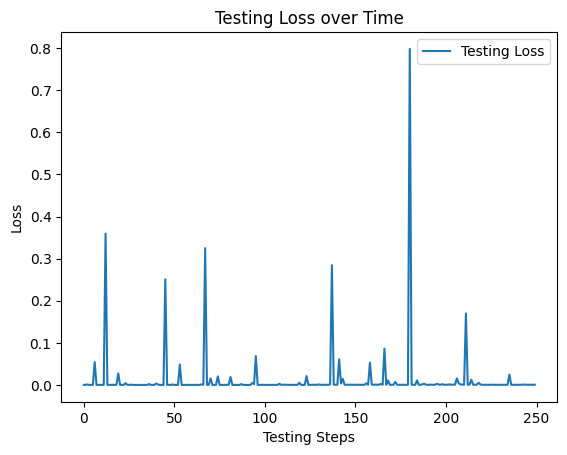

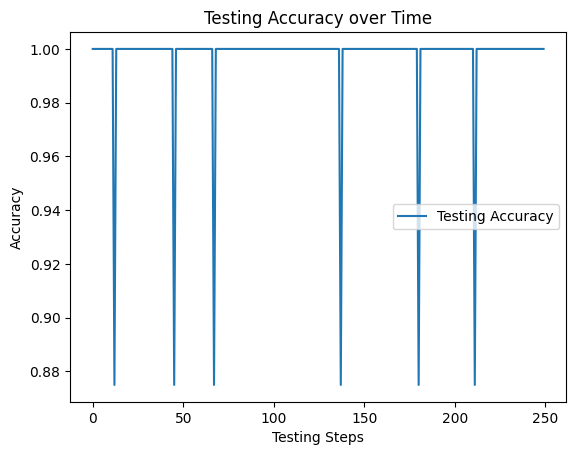

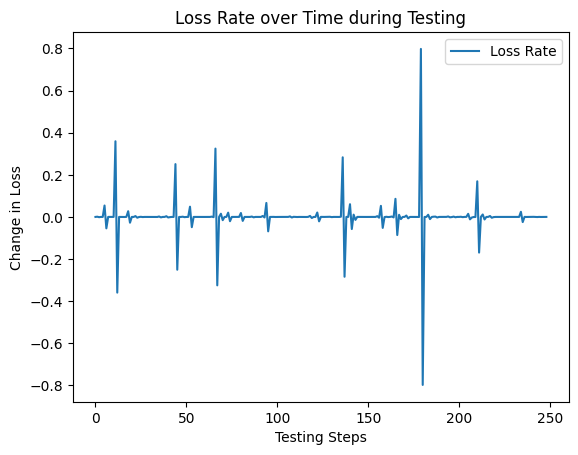

In [16]:
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Plotting Test loss over time
plt.plot(eval_losses, label="Testing Loss")
plt.xlabel("Testing Steps")
plt.ylabel("Loss")
plt.title("Testing Loss over Time")
plt.legend()
plt.savefig('Testing Loss over Time.png')
plt.show()

# Plotting Test accuracy over time
plt.plot(eval_accuracies, label="Testing Accuracy")
plt.xlabel("Testing Steps")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy over Time")
plt.legend()
plt.savefig('Test Accuracy over Time.png')
plt.show()

# Plotting loss rate (change in loss over test steps)
loss_rate = [eval_losses[i] - eval_losses[i-1] for i in range(1, len(eval_losses))]
plt.plot(loss_rate, label="Loss Rate")
plt.xlabel("Testing Steps")
plt.ylabel("Change in Loss")
plt.title("Loss Rate over Time during Testing")
plt.legend()
plt.savefig('Loss Rate over Time during Testing.png')
plt.show()

# Generating Confusion Matrix

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

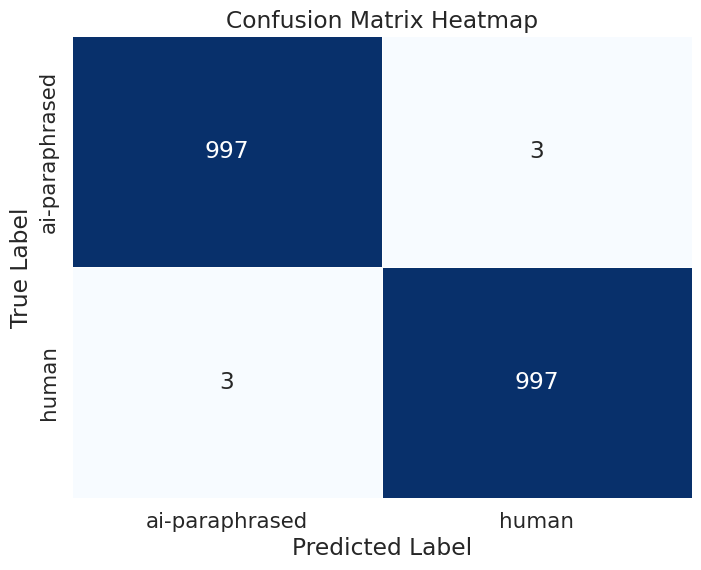

<Figure size 640x480 with 0 Axes>

In [18]:
# Plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set_theme(font_scale=1.4)  # Adjust font size if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['ai-paraphrased', 'human'], 
            yticklabels=['ai-paraphrased', 'human'],  
            linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('Test_Confusion_Matrix.png')
